# Data Collection Sandbox

This notebook contains snippets used in development of the data collection process. None of these code blocks were used in the final collection process.

In [ ]:
import os
import audio_metadata
import csv

mediadir = 'M:/Music'

genres = {}
genres['No Genre'] = 0

filelist = []

for root, dirs, files in os.walk(mediadir):
    for filename in files:
        if filename.lower().endswith(('.mp3', '.flac', '.wav')) and not filename.startswith('._'):
            try:
                md = audio_metadata.load(os.path.join(root, filename))
                #print(md['tags']['genre'])
                if 'genre' in md['tags']:
                    gs = [e for s in [t.split(';') for t in md['tags']['genre']] for e in s]
                    for g in gs:
                        if g in genres:
                            genres[g] += 1
                        else:
                            genres[g] = 1
                    filelist.append([os.path.join(root, filename), ';'.join(gs)])
                else:
                    genres['No Genre'] += 1
                    filelist.append([os.path.join(root, filename), None])
                if len(filelist) % 100 == 0:
                    print(len(filelist))
            except audio_metadata.UnsupportedFormat as ufe:
                pass
                #print(f"Error with {filename}, skipping")
            except audio_metadata.FormatError as fe:
                pass
                #print(f"Format error with {filename}, skipping")
print(genres)
with open('files.csv', 'w', newline='') as file:
    write = csv.writer(file)
    write.writerows(filelist)

with open('genres.csv', 'w', newline='') as file:
    write = csv.writer(file)
    write.writerows([[k, genres[k]] for k in genres])
print("Done")

8629679 44100
(128, 16855)
(128, 16855)


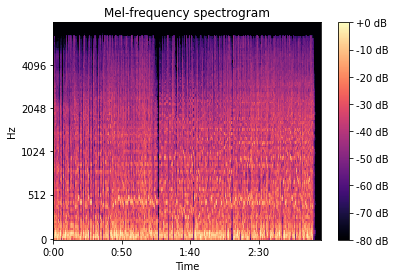

In [15]:
#for root, dirs, files in os.walk(mediadir):
#    for filename in files:
#        if filename.lower().endswith(('.mp3', '.flac', '.wav')) and not filename.startswith('._'):
import matplotlib.pyplot as plt
import matplotlib.image
import librosa, librosa.display
import numpy as np
#import matplotlib.image

samples, sample_rate = librosa.load("M:\Music\MP3s\junk\Moon Hooch - Acid Mountain.mp3")
print(len(samples), sample_rate)
melsgram = librosa.feature.melspectrogram(y=samples,sr=sample_rate)
#matplotlib.image.imsave('test.png', melsgram)

print(melsgram.shape)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(melsgram, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sample_rate,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

matplotlib.image.imsave('test.png', S_dB)

print(S_dB.shape)

In [19]:
import matplotlib.pyplot as plt
import math
import librosa
import numpy as np
import scipy.signal as signal
import pandas as pd

clip_dur = 1 # in seconds
df = None
metacolnames = ['label', 'filename', 'clipnum']
pixelcolnames = []
allcolnames = []

samples, sample_rate = librosa.load("M:\Music\MP3s\junk\Cory Henry - Seven.mp3")
real_clip_dur = clip_dur * 1.1
samples_per_clip = sample_rate * clip_dur
real_samples_per_clip = sample_rate * real_clip_dur

f, t, sxx = signal.spectrogram(samples, nfft=1024, return_onesided=True)

tbin_width = len(samples) / len(t)
song_dur = len(samples) / sample_rate
num_clips = math.floor(song_dur / clip_dur)
clip_sample_starts = [c * samples_per_clip for c in range(0, num_clips)]
clip_tbin_starts = [round(s / tbin_width) for s in clip_sample_starts]
tbins_per_clip = math.floor(samples_per_clip / tbin_width)
clip_tbin_ends = [s + tbins_per_clip for s in clip_tbin_starts]

Sxx_dB = 10*np.log10(sxx)

if df is None:
    pixelcolnames = [f'pixel{n}' for n in range(0, len(f) * tbins_per_clip)]
    allcolnames = metacolnames + pixelcolnames
    df = pd.DataFrame([], columns=allcolnames)

for c in range(0, num_clips):
    #print(Sxx_dB[:, clip_tbin_starts[c]:clip_tbin_ends[c]].shape, t[clip_tbin_starts[c]], t[clip_tbin_ends[c]])
    Sxx_dB_flat = np.ravel(Sxx_dB[:, clip_tbin_starts[c]:clip_tbin_ends[c]])
    #print(Sxx_dB_flat)
    df.append(pd.DataFrame(Sxx_dB_flat, columns=pixelcolnames, ignore_index=True))
    df.iloc[-1]['label'] = genre
    df.iloc[-1]['filename'] = fn
    df.iloc[-1]['clipnum'] = c

In [22]:
import math
import librosa
import numpy as np
import scipy.signal as signal
import os
import pandas as pd
import audio_metadata
import json

mediadir = "W:\Music\MP3s"
ofdir = "outfiles"
clip_dur = 1 # in seconds
nfft = 256

df = None
df_inuse = False
metacolnames = ['label', 'filename', 'clipnum']
pixelcolnames = []
allcolnames = []

genres = {}

lastdir = None

for root, dirs, files in os.walk(mediadir):
    if lastdir != root and df_inuse == True:
        fp = os.path.normpath(lastdir)
        print(f"Writing new datafile {os.path.join(ofdir, '--'.join(fp.split(os.sep)[2:] + ['data.csv']))}")
        # Write the previous directory's dataframe, just for safety
        df.to_csv(os.path.join(ofdir, '--'.join(fp.split(os.sep)[2:] + ['data.csv'])))
        with open(os.path.join(ofdir, '--'.join(fp.split(os.sep)[2:] + ['genres.json']), "w")) as genres_outfile:
            genres_outfile.write(json.dumps(genres))
        
        # Clear dataframe and re-init genres
        df = None
        df_inuse = False
        genres = {}
        lastdir = root

    for filename in files:
        if filename.lower().endswith(('.mp3', '.flac', '.wav')) and not filename.startswith('._'):
            print(os.path.join(root, filename))
            try:
                md = audio_metadata.load(os.path.join(root, filename))
                genre = None
                if 'genre' in md['tags']:
                    gs = [e for s in [t.split(';') for t in md['tags']['genre']] for e in s]
                    genre = gs[0]
                    for g in gs:
                        if g in genres:
                            genres[g] += 1
                        else:
                            genres[g] = 1
                else:
                    continue

                samples, sample_rate = librosa.load(os.path.join(root, filename))
                real_clip_dur = clip_dur * 1.1
                samples_per_clip = sample_rate * clip_dur
                real_samples_per_clip = sample_rate * real_clip_dur

                f, t, sxx = signal.spectrogram(samples, nfft=nfft, return_onesided=True)

                tbin_width = len(samples) / len(t)
                song_dur = len(samples) / sample_rate
                num_clips = math.floor(song_dur / clip_dur)
                clip_sample_starts = [c * samples_per_clip for c in range(0, num_clips)]
                clip_tbin_starts = [round(s / tbin_width) for s in clip_sample_starts]
                tbins_per_clip = math.floor(samples_per_clip / tbin_width)
                clip_tbin_ends = [s + tbins_per_clip for s in clip_tbin_starts]

                Sxx_dB = 10*np.log10(sxx)

                if df is None:
                    pixelcolnames = [f'pixel{n}' for n in range(0, len(f) * tbins_per_clip)]
                    allcolnames = metacolnames + pixelcolnames
                    df = pd.DataFrame([], columns=allcolnames)
                    df_inuse = True
                    if lastdir is None:
                        lastdir = root

                for c in range(0, num_clips):
                    #print(Sxx_dB[:, clip_tbin_starts[c]:clip_tbin_ends[c]].shape, t[clip_tbin_starts[c]], t[clip_tbin_ends[c]])
                    Sxx_dB_flat = np.ravel(Sxx_dB[:, clip_tbin_starts[c]:clip_tbin_ends[c]])
                    #print(Sxx_dB_flat)
                    df = pd.concat([df, pd.DataFrame(Sxx_dB_flat.reshape(1, -1), columns=pixelcolnames)])
                    df.iloc[-1, df.columns.get_loc('label')] = genre
                    df.iloc[-1, df.columns.get_loc('filename')] = filename
                    df.iloc[-1, df.columns.get_loc('clipnum')] = c

            except audio_metadata.UnsupportedFormat as ufe:
                pass
                #print(f"Error with {filename}, skipping")
            except audio_metadata.FormatError as fe:
                pass
                #print(f"Format error with {filename}, skipping")

fp = os.path.normpath(lastdir)
print(f"Writing new datafile {os.path.join(ofdir, '--'.join(fp.split(os.sep)[2:] + ['data.csv']))}")
# Write the previous directory's dataframe, just for safety
df.to_csv(os.path.join(ofdir, '--'.join(fp.split(os.sep)[2:] + ['data.csv'])))
with open(os.path.join(ofdir, '--'.join(fp.split(os.sep)[2:] + ['genres.json']), "w")) as genres_outfile:
    genres_outfile.write(json.dumps(genres))

W:\Music\MP3s\14 - Eric Clapton - Layla.mp3


    divide by zero encountered in log10


W:\Music\MP3s\14 -  , The Yardbirds - For Your Love.mp3
W:\Music\MP3s\144 - King Harvest - A Little Bit Like Magic.mp3
W:\Music\MP3s\19 - Eric Clapton - Lay Down Sally.mp3
W:\Music\MP3s\2 - Ian & Sylvia - Early Morning Rain.mp3
W:\Music\MP3s\218 - Linda Ronstadt - You're No Good.mp3
W:\Music\MP3s\224 - Michael Jackson - Ben.mp3
W:\Music\MP3s\248 - Alicia Bridges - I Love The Nightlife (Disco 'Round).mp3
W:\Music\MP3s\250 - Michael Jackson - Ben.mp3
W:\Music\MP3s\259 - George McCrae - Rock Your Baby.mp3
W:\Music\MP3s\268 - The Miracles - Love Machine (Pt. 1).mp3
W:\Music\MP3s\275 - Mouth & Macneal - How Do You Do_.mp3
W:\Music\MP3s\28 - Gregory Alan Isakov - The Stable Song.mp3
W:\Music\MP3s\288 - Eric Clapton - Wonderful Tonight.mp3
W:\Music\MP3s\306 - Firefall - Just Remember I Love You.mp3
W:\Music\MP3s\345 - Poco - Crazy Love.mp3
W:\Music\MP3s\346 - Poco - Heart Of The Night.mp3
W:\Music\MP3s\353 - Shocking Blue - Venus.mp3
W:\Music\MP3s\355 - The Sweet - Ballroom Blitz.mp3
W:\Music

KeyboardInterrupt: 

In [7]:
import numpy as np
cols = [f"col{x}" for x in range(10)]
datarows = []
for i in range(10):
    data = np.arange(i, i+10)
    datarows.append(dict(zip(cols, data)))

import csv
f = open('test.csv', 'w', newline='')
dw = csv.DictWriter(f, fieldnames=cols)
dw.writeheader()
dw.writerows(datarows)
f.close()

: 